In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import os
import random
import sys

from mpl_toolkits.axes_grid1 import make_axes_locatable
import magic
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import scipy.optimize

from speechmatching.recording import Recording, Group, load_directory
from speechmatching.model import Transcriptor

In [3]:
PLOTS_DIR = 'plots'

if not os.path.isdir(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

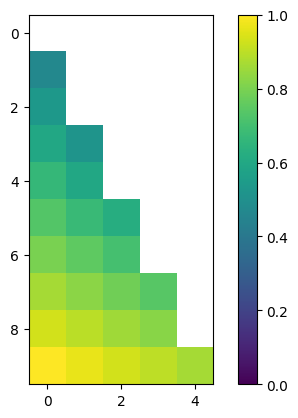

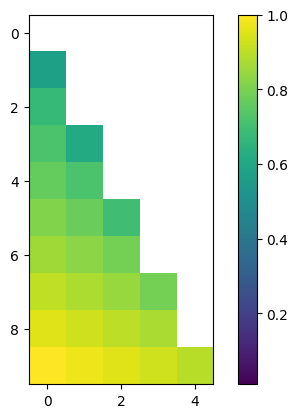

In [4]:
dim = 10
ms = np.arange(10)
ts = np.arange(10)
l = 3

jaro = np.array([
    [
        (0 if m == 0 else 1/3 * ((m/dim)+(m/dim)+(m-t)/m))
        if t < m // 2 else np.nan
        for t in np.arange(0, dim//2)
    ]
    for m in np.arange(1, dim+1)
])
plt.imshow(jaro, vmin=0, vmax=1)
plt.colorbar()
plt.show()

winkler = np.array([
    [
        (
            (0 if m == 0 else 1/3 * ((m/dim)+(m/dim)+(m-t)/m))
            + 0.1 * max(0, min(l, m-t*2)) * (1-(0 if m == 0 else 1/3 * ((m/dim)+(m/dim)+(m-t)/m)))
        )
        if t < m // 2 else np.nan
        for t in np.arange(0, dim//2)
    ]
    for m in np.arange(1, dim+1)
])
plt.imshow(winkler, vmin=0.01, vmax=1, )
plt.colorbar()
plt.show()

In [5]:
from speechmatching.utils import ensure_norm_algs_dict, ensure_algs_dict

norm_algs = ensure_norm_algs_dict({'soundex': 3, 'metaphone': 4, 'nysiis': 5})
print(ensure_algs_dict(['hamming', 'damerau'], norm_algs))
print(ensure_algs_dict({'soundex': {'hamming': 0.1}, 'metaphone': {'hamming': 0.5, 'damerau': 0.3}}, norm_algs))
print(ensure_algs_dict(['soundex', 'nysiis'], ['hamming', 'jaro', 'damerau']))

({'hamming': 0.5, 'damerau': 0.5}, {'hamming': {'soundex': 0.25, 'metaphone': 0.3333333333333333, 'nysiis': 0.4166666666666667}, 'damerau': {'soundex': 0.25, 'metaphone': 0.3333333333333333, 'nysiis': 0.4166666666666667}})
({'soundex': {'hamming': 1.0}, 'metaphone': {'hamming': 0.625, 'damerau': 0.37499999999999994}}, {'soundex': 0.25, 'metaphone': 0.3333333333333333, 'nysiis': 0.4166666666666667})
({'soundex': 0.5, 'nysiis': 0.5}, {'soundex': {'hamming': 0.3333333333333333, 'jaro': 0.3333333333333333, 'damerau': 0.3333333333333333}, 'nysiis': {'hamming': 0.3333333333333333, 'jaro': 0.3333333333333333, 'damerau': 0.3333333333333333}})


# Experiments

In [6]:
RECORDINGS_DIR = 'recordings'
ALGS_NORM_LIST = [
    'soundex',
    'nysiis',
    'metaphone'
]
ALGS_NORM = {
    'soundex': 'Soundex',
    'nysiis': 'NYSIIS',
    'metaphone': 'Metaphone'
}
ALGS_MATCH_LIST = [
    'hamming',
    'levenshtein',
    'damerau',
    'jaro',
    'winkler'
]
ALGS_MATCH = {
    'hamming': 'Hamming',
    'levenshtein': 'Levenshtein',
    'damerau': 'Damerau-Levenshtein',
    'jaro': 'Jaro',
    'winkler': 'Jaro-Winkler'
}
SORTED_KEYS_NUMBERS = [
    'One',
    'Two',
    'Three',
    'Four',
    'Five',
    'Six',
    'Seven',
    'Eight',
    'Nine',
    'Ten'
]
SORTED_KEYS_YESNO = [
    'No',
    'Yes'
]
SORTED_KEYS = SORTED_KEYS_YESNO + SORTED_KEYS_NUMBERS
DAGBANI_MAP = {
    'Ayobu': 'Ayɔbu',
    'Ayopoin': 'Ayɔpɔin',
    'Apoin': 'Apɔin',
    'Awei': 'Awɛi',
    'ZagYini': 'Zaɣ’ yini'
}
    

def get_combinations(data: list):
    result = []
    for i in range(1, len(data)+1):
        result.extend([list(d) for d in itertools.combinations(data, i)])
    return result

ALGS_NORM_COMBINATIONS = get_combinations(ALGS_NORM.keys())
ALGS_MATCH_COMBINATIONS = get_combinations(ALGS_MATCH.keys())


In [8]:
groups = {}

for directory in os.listdir(RECORDINGS_DIR):
    parts = directory.split(' - ')
    if len(parts) == 1:
        continue
    labels = {
        'en': parts[0],
        'dag': parts[1:]
    }
    groups[labels['en']] = load_directory(
        os.path.join(RECORDINGS_DIR, directory),
        identifier=labels['en'],
        labels=labels
    )

Loading file 5/669: recordings/Two - Ayi/recording-28bc06a5-21a1-4a65-8b19-6e8ee979b74d.3gp
Loading file 6/669: recordings/Two - Ayi/recording-aa2b3a9d-6d30-4740-a10a-ec7d7b13a6ef.3gp
Loading file 12/669: recordings/Two - Ayi/recording-4fc708a9-738d-4f5f-8483-c3b45b323f7e.3gp
Loading file 13/669: recordings/Two - Ayi/recording-f1c9bb0c-5bde-4e26-af79-b25c17f72f00.3gp
Loading file 14/669: recordings/Two - Ayi/recording-904b4ba1-0b63-43fc-adc2-190a1a9193ff.3gp
Loading file 18/669: recordings/Two - Ayi/recording-16a76af3-b657-42e8-86ba-0ccc02afd966.3gp
Loading file 19/669: recordings/Two - Ayi/recording-352ae694-2d96-4b11-8e6a-96c9e80ed9f5.3gp
Loading file 22/669: recordings/Two - Ayi/recording-2bdd09ca-8649-4a0a-a3bc-38c25dde37df.3gp
Loading file 27/669: recordings/Two - Ayi/recording-98546d2b-0860-4e35-98f2-1d887548fca8.3gp
Loading file 28/669: recordings/Two - Ayi/recording-fbbf886c-267a-40ee-9a93-0b381eb5f0cc.3gp
Loading file 29/669: recordings/Two - Ayi/recording-a0724d55-d743-4d43-b

## Model

In [11]:
def plot_algs_image(data, no_x=False, no_y=False, name=None, no_y_label=False):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(data)
    plt.yticks(np.arange(len(ALGS_NORM_COMBINATIONS)),
               labels=([] if no_y else join_algs(ALGS_NORM_COMBINATIONS)),
               rotation='horizontal')
    if not no_y and not no_y_label:
            plt.ylabel('norm. algs.')
    plt.xticks(np.arange(len(ALGS_MATCH_COMBINATIONS)),
               labels=([] if no_x else join_algs(ALGS_MATCH_COMBINATIONS)),
               rotation='vertical')
    if not no_x:
        plt.xlabel('matching algorithms')
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
                 format=tkr.FormatStrFormatter('%.2f'))
    if name is not None:
        plt.savefig(os.path.join('plots', 'algs_comparison_{}.pdf'.format(name)), bbox_inches='tight')
    plt.show()

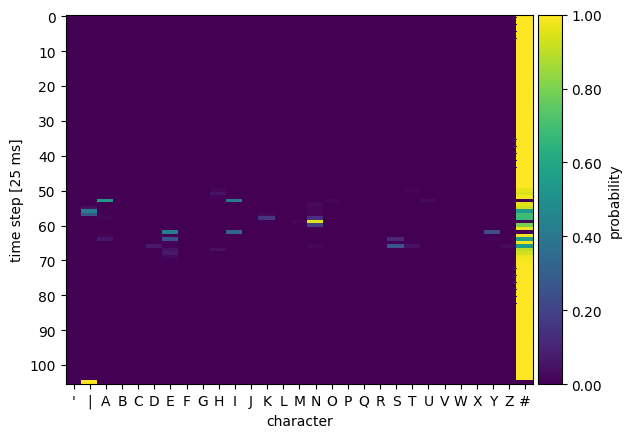

0.577 & ANE \\
0.422 & INE \\


In [12]:
key = 'Four'
#sample = groups[key].recording('recordings/Four - Anahi/recording-61f321ae-4073-4dad-8664-ca801c05aeae.3gp')
sample = groups['Eight'].recording('recordings/Eight - Anii/recording-25ad2f6b-8b23-4107-a91d-75422febe027.3gp')
#sample = groups['Nine'].recording('recordings/Nine - Awei/recording-bd8b8b1b-4d3f-42b2-8c7b-2e6ad8f76751.3gp')

figsize = (6.4, 10)

plt.figure()
ax = plt.gca()
im = plt.pcolor(sample.transcript.probabilities, vmin=0, vmax=1)
im.set_edgecolor('face')
tokens = sample.transcript.tokens
plt.xticks(np.arange(len(tokens))+0.5, labels=[c.upper() for c in tokens])
y = np.arange(0, sample.transcript.probabilities.shape[0], 10)
plt.yticks(y+0.5, labels=y)
plt.xlabel('character')
plt.ylabel('time step [25 ms]')
plt.gca().invert_yaxis()
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
                 format=tkr.FormatStrFormatter('%.2f'), label='probability')
plt.savefig('plots/model_probabilities.pdf', bbox_inches='tight')
plt.show()

for word, probability in sorted(
    sample.transcript.probable_texts(min_probability=0.4).items(),
    key=lambda x: x[1],
    reverse=True
):
    print(r'{} & {} \\'.format(str(probability)[:5], word))

## In-word comparison

In [13]:
def get_in_word_similarities(group: Group):
    print(group.identifier)
    similarities = {}
    recordings = group.recordings()
    for algs_norm in [['metaphone']]:
        for algs_match in ALGS_MATCH_COMBINATIONS:
            scores = []
            for recording in recordings:
                #if i == len(recordings) - 1:
                #    continue
                scores.append(recording.similarity(recordings, algs_norm, algs_match))
            similarities[(tuple(algs_norm), tuple(algs_match))] = scores
    return similarities

in_word_similarities = {name: get_in_word_similarities(group) for name, group in groups.items()}

Two
No
Seven
Four
Nine
One
Three
Six
Five
Ten
Yes
Eight


In [14]:
def get_hist_scores(scores, bins=100):
    scores = [sum(d) / len(d) for d in scores]
    hist, _ = np.histogram(scores, bins=bins, range=(0, 1), density=True)
    hist /= sum(hist)
    return hist

def make_name(name: str, quoted=False, newline=False):
    group = groups[name]
    quote = '\'' if quoted else ''
    dagbani = [DAGBANI_MAP[s] if s in DAGBANI_MAP else s for s in group.label('dag')]
    return '{}{}({}{}{})'.format(
        ('\n' if newline else ',\n').join([ #'/'
            quote+s+quote for s in dagbani
        ]),
        '\n' if newline else ' ',
        quote,
        group.label('en'),
        quote
    )

def plot_average_in_word_single(in_word_similarities, norm, match, name, plot=True, show=True):
    scores = in_word_similarities[name][((norm,), (match,))]
    scores = [sum(d) / len(d) for d in scores]
    plt.rcParams.update({'font.size': 17})
    plt.hist(scores, bins=40)
    plt.xlabel('average similarity')
    plt.ylabel('counts')
    #plt.title('Histogram of average {} in-word {} similarities for {}'
    #          .format(ALGS_NORM[norm], ALGS_MATCH[match], make_name(name)))
    if plot:
        plt.savefig(os.path.join(PLOTS_DIR, 'single_in-word_{}_{}_{}.pdf'.format(name, norm, match)),
                    bbox_inches='tight')
    if show:
        plt.show()
    plt.close()
    plt.rcParams.update(matplotlib.rcParamsDefault)
    return scores

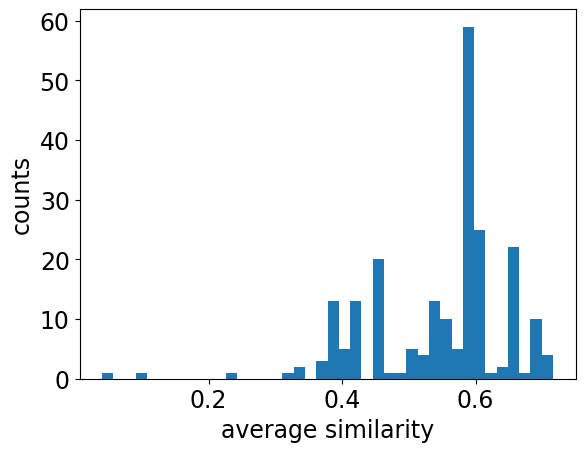

0.715 & 3 & IKNOWT & IKNT \\
0.682 & 8 & IMNOT & IMNT \\
0.660 & 9 & INOT & INT \\
0.660 & 6 & INIGHT & INT \\
0.660 & 3 & INAT & INT \\
0.611 & 5 & IKNOWIT & IKNWT \\
0.603 & 11 & INOW & IN \\
0.603 & 4 & INO & IN \\
0.585 & 58 & IKNOW & IKN \\
0.537 & 5 & ATNIGHT & ATNT \\
0.520 & 2 & ANDTHEN & ANT0N \\
0.456 & 8 & ANIGHT & ANT \\
0.456 & 4 & ANDI & ANT \\
0.456 & 3 & AND & ANT \\
0.456 & 2 & ANIT & ANT \\
0.420 & 2 & UNIGHT & UNT \\
0.418 & 4 & ONIGHT & ONT \\
0.415 & 2 & IMA & IM \\
0.404 & 2 & ILIKE & ILK \\
0.382 & 2 & I & I \\
0.379 & 3 & ANE & AN \\
0.379 & 2 & AN & AN \\


In [15]:
name = 'Four'
norm = 'metaphone'
scores = plot_average_in_word_single(in_word_similarities, norm, 'jaro', name)
data = {}
for score, recording in zip(scores, groups[name].recordings()):
    k = (score, recording.transcript.text, recording.transcript.normalize(norm))
    if k not in data:
        data[k] = 0
    data[k] += 1
for (score, text, metaphone), count in sorted(data.items(), key=lambda x: (x[0][0], x[1]), reverse=True):
    if count > 1:
        print(str(score)[:5], '&', count, '&', text, '&', metaphone, r'\\')

In [16]:
def join_algs(algs) -> str:
    if type(algs) not in (list, tuple):
        return algs
    if any(type(d) in (list, tuple) for d in algs):
        return [join_algs(d) for d in algs]
    return ', '.join([d[:3]+'.' if len(algs) > 1 else d for d in algs])
    
def plot_average_in_word(in_word_similarities, norm, name, plot=True, show=True):
    image = []
    alg_names = []
    for algs, scores in in_word_similarities[name].items():
        if len(algs[0]) > 1 or len(algs[1]) > 2 or algs[0][0] != norm:
            continue
        hist = get_hist_scores(scores)
        image.append(hist)
        alg_names.append(join_algs(algs[1]))
    image = np.array(image)
    plt.figure()
    ax = plt.gca()
    im = plt.pcolor(image)
    im.set_edgecolor('face')
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(len(alg_names))+0.5, labels=alg_names, rotation='horizontal')
    y = np.arange(0, 101, 20)
    plt.xticks(y, labels=y/100)
    plt.xlabel('average similarity')
    plt.ylabel('similarity algorithm')
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
                 format=tkr.FormatStrFormatter('%.2f'), label='occurence')
    #plt.title('Histogram of average {} in-word similarities for {}'.format(ALGS_NORM[norm], make_name(name)))
    if plot:
        plt.savefig(os.path.join(PLOTS_DIR, 'in-word_{}_{}.pdf'.format(name, norm)), bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

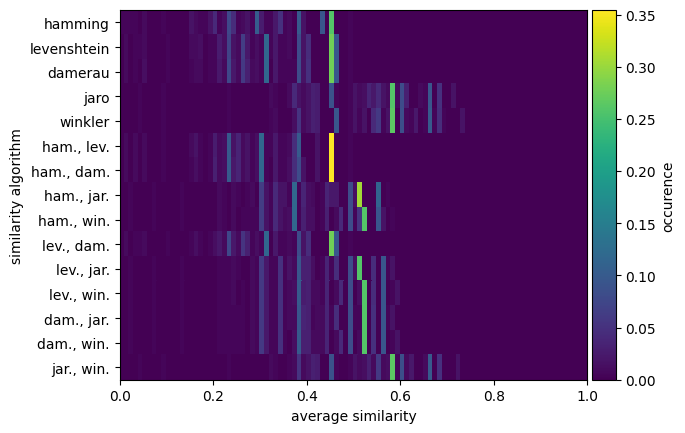

In [17]:
plot_average_in_word(in_word_similarities, 'metaphone', 'Four')

In [18]:
def plot_average_in_word_multi(in_word_similarities, norm, match, plot=True, show=True):
    image = []
    names = []
    for name in SORTED_KEYS:
        scores = in_word_similarities[name][((norm,), (match,))]
        hist = get_hist_scores(scores)
        image.append(hist)
        names.append(make_name(name))
    image = np.array(image)
    plt.figure()
    ax = plt.gca()
    im = plt.pcolor(image)
    im.set_edgecolor('face')
    plt.gca().invert_yaxis()
    y = np.arange(0, 101, 20)
    plt.xticks(y, labels=y/100)
    plt.yticks(np.arange(len(names))+0.5, labels=names, rotation='horizontal')
    plt.xlabel('average in-word similarity')
    plt.ylabel('word')
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
                 format=tkr.FormatStrFormatter('%.2f'), label='occurence')
    #plt.title('Histogram of average {} in-word {} similarities'.format(ALGS_NORM[norm], ALGS_MATCH[match]))
    if plot:
        plt.savefig(os.path.join(PLOTS_DIR, 'multi_in-word_{}_{}.pdf'.format(norm, match)), bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

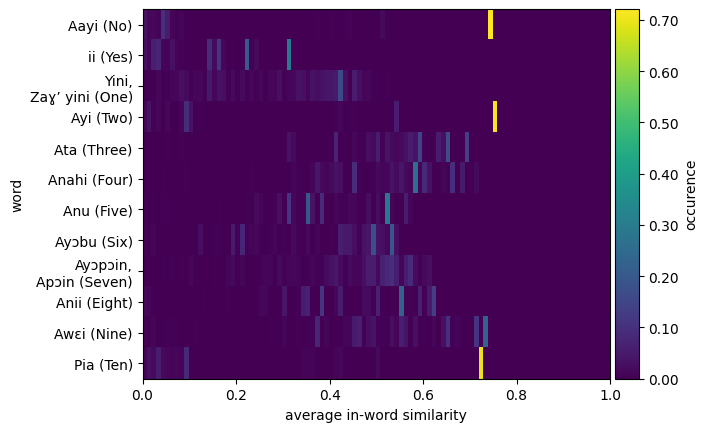

In [19]:
plot_average_in_word_multi(in_word_similarities, 'metaphone', 'jaro')

## Cross-word comparison

In [20]:
def compare_one_to_n_single(name, groups, strategy, select_n=None, n=1, fraction=None,
                            algs_norm='metaphone', algs_match='winkler', min_probability=None,
                            or_best=False, choose_best=False, or_best_char=False):
    # top (best match)
    # min (top select_n need to match)
    # best (select_n best matches are taken, and most frequent is selected)
    # fraction (select_n best matches are tkane, and name occuring with rate higher than fraction is selected)
    #if select_n is not None:
    #    assert n >= select_n
    recording = groups[name].sample()[0]
    groups = list(groups.values()) * n
    others = []
    for group in groups:
        while True:
            candidate = group.sample()[0]
            if candidate != recording and candidate not in others:
                others.append(candidate)
                break
    similarities = recording.similarity(others, algs_norm, algs_match,
                                        min_probability=min_probability,
                                        or_best=or_best, choose_best=choose_best,
                                        use_factor=False, or_best_char=or_best_char)
    similarities = sorted(enumerate(similarities), key=lambda x: x[1])
    min_i = 1
    if strategy in ('best', 'fraction', 'min'):
        min_i = select_n
    matched = [
        groups[i].identifier
        for i, score in similarities
        if score >= similarities[-min_i][1]
    ]
    counts = {name: matched.count(name) for name in matched}
    #print(counts)
    counts = sorted(counts.items(), key=lambda x: x[1])
    if strategy == 'fraction':
        counts = [d for d in counts if d[1]/len(matched) >= fraction]
    if strategy == 'min':
        counts = [d for d in counts if d[1] >= select_n]
    matched = [
        name
        for name, count in counts
        if count == counts[-1][1]
    ]
    return matched

def compare_cross_many(groups, strategy, samples=100, n=1, select_n=None, fraction=None,
                       algs_norm='metaphone', algs_match='winkler', verbose=True,
                       min_probability=None, or_best=False, choose_best=False,
                       or_best_char=False):
    results = {}
    for name in groups.keys():
        if verbose:
            print(name)
        indecision_count = 0
        match_count = {name: 0 for name in groups.keys()}
        random.seed(0)
        for i in range(samples):
            while True:
                result = compare_one_to_n_single(name, groups, strategy, n=n,
                                                 select_n=select_n, fraction=fraction,
                                                 algs_norm=algs_norm, algs_match=algs_match,
                                                 min_probability=min_probability, or_best=or_best,
                                                choose_best=choose_best, or_best_char=or_best_char)
                if len(result) != 1:
                    indecision_count += 1
                    continue
                match_count[result[0]] += 1
                break
        results[name] = {
            'indecisions': indecision_count,
            'match_counts': match_count,
            'correct': match_count[name]
        }
    return results

In [21]:
print(compare_one_to_n_single('Four', groups, 'top', n=10))
print(compare_one_to_n_single('Four', groups, 'min', n=10, select_n=5))
print(compare_one_to_n_single('Four', groups, 'best', n=10, select_n=10))
print(compare_one_to_n_single('Four', groups, 'fraction', n=10, select_n=10, fraction=0.6))

['Four']
[]
['Eight', 'Four']
[]


In [22]:
groups_numbers = {k: v for k, v in groups.items() if k in SORTED_KEYS_NUMBERS}
print(len(groups_numbers))
groups_yesno = {k: v for k, v in groups.items() if k in SORTED_KEYS_YESNO}
print(len(groups_yesno))

10
2


In [23]:
compare_cross_many(groups_yesno, 'top', samples=10000, n=10, select_n=1, min_probability=0.45, or_best=True)

No
Yes


{'No': {'indecisions': 748,
  'match_counts': {'No': 8744, 'Yes': 1256},
  'correct': 8744},
 'Yes': {'indecisions': 1746,
  'match_counts': {'No': 1331, 'Yes': 8669},
  'correct': 8669}}

### Best match from one each

In [21]:
y_names = [make_name(name, newline=True) for name in SORTED_KEYS_NUMBERS]

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


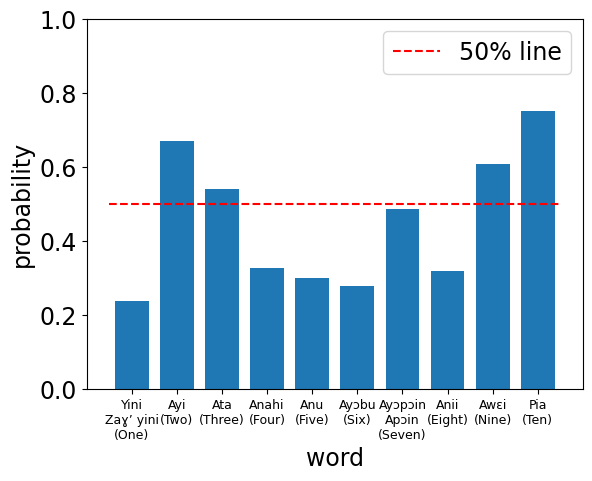

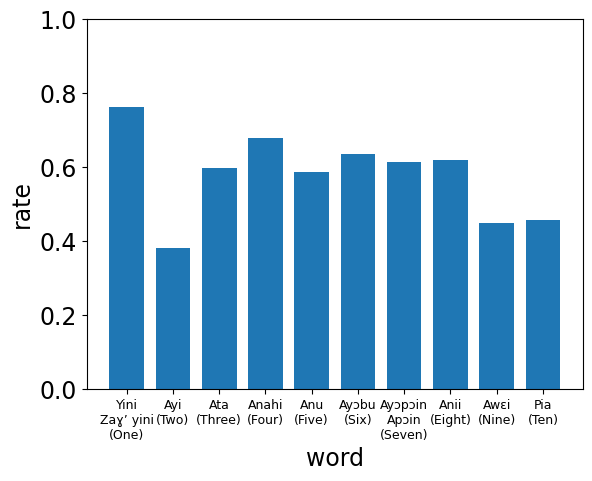

In [123]:
samples = 10000
algs_norm = 'metaphone'
algs_match = 'jaro'
result_1_of_1 = compare_cross_many(groups_numbers, 'top', samples=samples, n=1,
                                   algs_norm=algs_norm, algs_match=algs_match,
                                   min_probability=None, or_best=True)

y_1_of_1 = [result_1_of_1[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]

plt.rcParams.update({'font.size': 17})
plt.ylim([0, 1])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS)), y_1_of_1, width=0.75)
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('probability of matching correct number 1 to 1')
plt.ylabel('probability')
plt.xlabel('word')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_prob_{}_{}.pdf'.format(algs_norm, algs_match)),
            bbox_inches='tight')
plt.show()

y_bad_1_of_1 = [result_1_of_1[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
plt.ylim([0, max(1, max(y_bad_1_of_1))])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS)), y_bad_1_of_1, width=0.75)
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('indecision rate when matching 1 to 1')
plt.ylabel('rate')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_indec_{}_{}.pdf'.format(algs_norm, algs_match)),
            bbox_inches='tight')
plt.show()
plt.rcParams.update(matplotlib.rcParamsDefault)

In [23]:
results_1_to_1_algs = {}
for algs_norm in ALGS_NORM_COMBINATIONS:
    if len(algs_norm) > 20 or None in algs_norm:
        continue
    data_norm = {}
    for algs_match in ALGS_MATCH_COMBINATIONS:
        if len(algs_match) > 20:
            continue
        print(algs_norm, algs_match)
        data_norm[tuple(algs_match)] = compare_cross_many(groups_numbers, 'top', samples=10000, n=1,
                                           algs_norm=algs_norm, algs_match=algs_match, verbose=False)
    results_1_to_1_algs[tuple(algs_norm)] = data_norm

['soundex'] ['hamming']
['soundex'] ['levenshtein']
['soundex'] ['damerau']
['soundex'] ['jaro']
['soundex'] ['winkler']
['soundex'] ['hamming', 'levenshtein']
['soundex'] ['hamming', 'damerau']
['soundex'] ['hamming', 'jaro']
['soundex'] ['hamming', 'winkler']
['soundex'] ['levenshtein', 'damerau']
['soundex'] ['levenshtein', 'jaro']
['soundex'] ['levenshtein', 'winkler']
['soundex'] ['damerau', 'jaro']
['soundex'] ['damerau', 'winkler']
['soundex'] ['jaro', 'winkler']
['soundex'] ['hamming', 'levenshtein', 'damerau']
['soundex'] ['hamming', 'levenshtein', 'jaro']
['soundex'] ['hamming', 'levenshtein', 'winkler']
['soundex'] ['hamming', 'damerau', 'jaro']
['soundex'] ['hamming', 'damerau', 'winkler']
['soundex'] ['hamming', 'jaro', 'winkler']
['soundex'] ['levenshtein', 'damerau', 'jaro']
['soundex'] ['levenshtein', 'damerau', 'winkler']
['soundex'] ['levenshtein', 'jaro', 'winkler']
['soundex'] ['damerau', 'jaro', 'winkler']
['soundex'] ['hamming', 'levenshtein', 'damerau', 'jaro']
[

In [27]:
get_values = lambda key, type_: np.array([
    [
        data_match[key][type_] / 10000
        for _, data_match in data_norm.items()
    ]
    for _, data_norm in results_1_to_1_algs.items()
])
all_correct = np.array([get_values(k, 'correct') for k in SORTED_KEYS_NUMBERS])
all_indecision = np.array([get_values(k, 'indecisions') for k in SORTED_KEYS_NUMBERS])

In [28]:
def plot_algs_image(data, no_x=False, no_y=False, name=None, no_y_label=False):
    plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal')
    im = plt.pcolor(data)
    im.set_edgecolor('face')
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(len(ALGS_NORM_COMBINATIONS))+0.5,
               labels=([] if no_y else join_algs(ALGS_NORM_COMBINATIONS)),
               rotation='horizontal')
    if not no_y and not no_y_label:
            plt.ylabel('norm. algs.')
    plt.xticks(np.arange(len(ALGS_MATCH_COMBINATIONS))+0.5,
               labels=([] if no_x else join_algs(ALGS_MATCH_COMBINATIONS)),
               rotation='vertical')
    if not no_x:
        plt.xlabel('similarity algorithms')
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
                 format=tkr.FormatStrFormatter('%.2f'))
    if name is not None:
        plt.savefig(os.path.join('plots', 'algs_comparison_{}.pdf'.format(name)), bbox_inches='tight')
    plt.show()

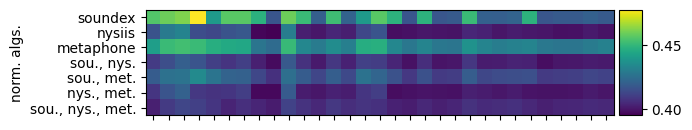

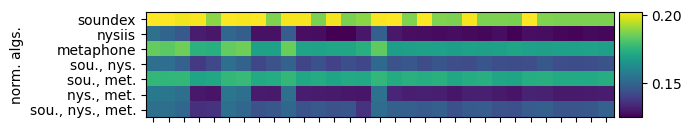

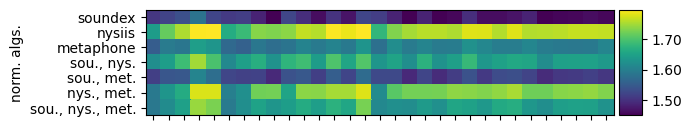

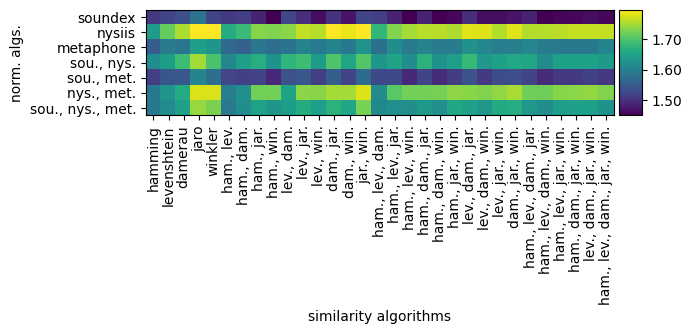

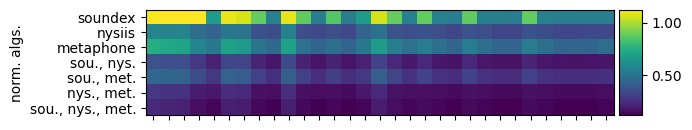

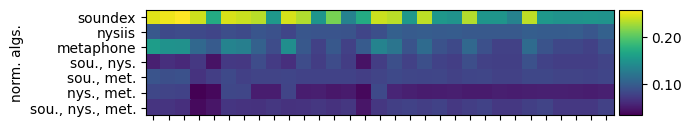

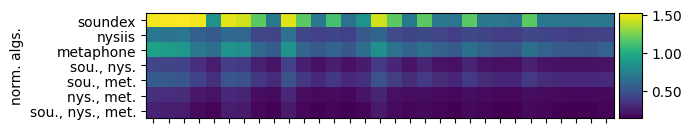

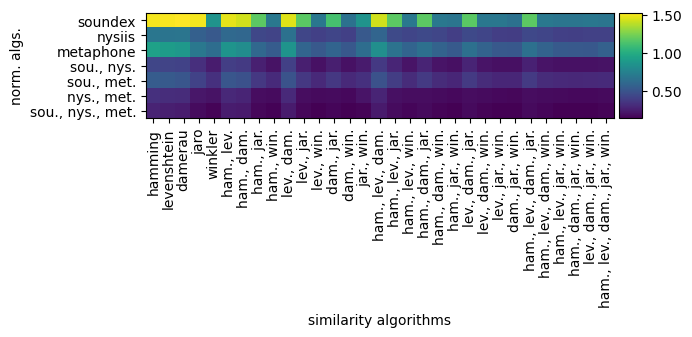

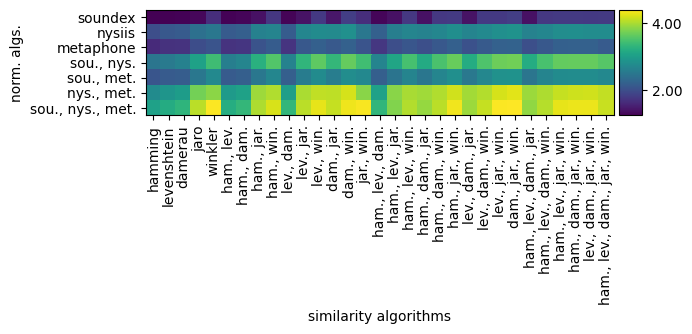

In [121]:
mean1 = all_correct.mean(axis=0)
std1 = all_correct.std(axis=0)
normed1 = mean1 / std1
normed1 = mean1 / (0.1+std1)
mean2 = all_indecision.mean(axis=0)
std2 = all_indecision.std(axis=0)
normed2 = mean2 / std2
normed2 = mean2 * (1.1+std2)
normed_all = normed1 / np.sqrt(normed2)

plot_algs_image(mean1, no_x=True, name='1_to_1_correct_mean')
plot_algs_image(std1, no_x=True, name='1_to_1_correct_std')
plot_algs_image(normed1, no_x=True, name='1_to_1_correct')
plot_algs_image(normed1, name='1_to_1_correct_x')
plot_algs_image(mean2, no_x=True, name='1_to_1_indecision_mean')
plot_algs_image(std2, no_x=True, name='1_to_1_indecision_std')
plot_algs_image(normed2, no_x=True, name='1_to_1_indecision')
plot_algs_image(normed2, name='1_to_1_indecision_x')
plot_algs_image(normed_all, name='1_to_1_combined')

In [122]:
for d in sorted(
    [
        (normed_all[i, j], i, j, ALGS_NORM_COMBINATIONS[i], ALGS_MATCH_COMBINATIONS[j])
        for i in range(normed_all.shape[0])
        for j in range(normed_all.shape[1])
    ],
    key=lambda d: d[0],
    reverse=True
):
    print(r'{} & {} & {} \\'.format(str(d[0])[:5], ', '.join(d[3]), ', '.join(d[4])))

4.412 & soundex, nysiis, metaphone & damerau, jaro, winkler \\
4.390 & soundex, nysiis, metaphone & levenshtein, jaro, winkler \\
4.389 & soundex, nysiis, metaphone & winkler \\
4.377 & soundex, nysiis, metaphone & jaro, winkler \\
4.338 & soundex, nysiis, metaphone & hamming, jaro, winkler \\
4.326 & soundex, nysiis, metaphone & damerau, winkler \\
4.316 & soundex, nysiis, metaphone & levenshtein, damerau, jaro, winkler \\
4.314 & soundex, nysiis, metaphone & hamming, damerau, jaro, winkler \\
4.297 & soundex, nysiis, metaphone & levenshtein, winkler \\
4.294 & soundex, nysiis, metaphone & hamming, levenshtein, jaro, winkler \\
4.266 & nysiis, metaphone & damerau, jaro, winkler \\
4.217 & soundex, nysiis, metaphone & hamming, winkler \\
4.211 & nysiis, metaphone & levenshtein, jaro, winkler \\
4.206 & nysiis, metaphone & damerau, winkler \\
4.183 & nysiis, metaphone & hamming, jaro, winkler \\
4.183 & nysiis, metaphone & levenshtein, damerau, jaro, winkler \\
4.172 & nysiis, metaphone

In [114]:
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['jaro', 'winkler', 'damerau']
result_1_of_1_best = compare_cross_many(groups_numbers, 'top', samples=samples, n=1,
                                        algs_norm=algs_norm, algs_match=algs_match)

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


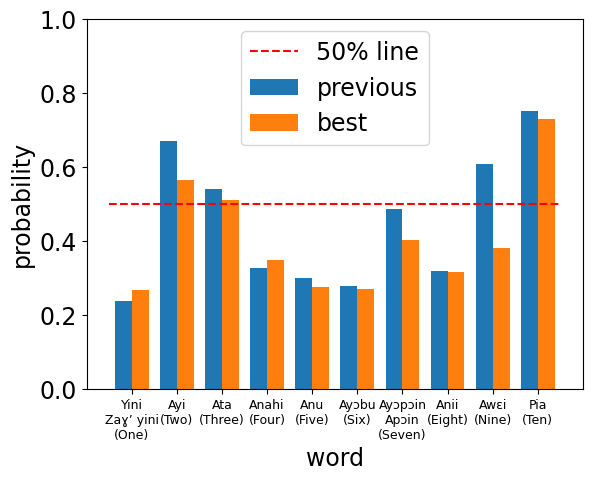

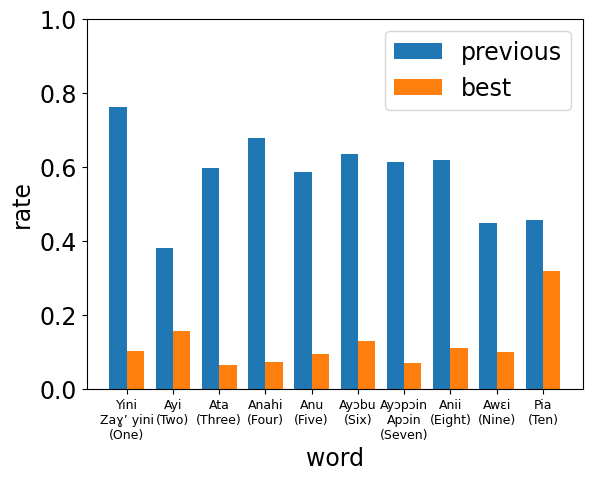

In [116]:
samples = 10000
y_1_of_1_best = [result_1_of_1_best[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
full_width = 0.75
n_bars = 2
width = full_width / n_bars
plt.rcParams.update({'font.size': 17})
plt.ylim([0, 1])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*0,
        [result_1_of_1[name]['correct']/samples for name in SORTED_KEYS_NUMBERS],
        width=width, label='previous')
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*1,
        y_1_of_1_best,
        width=width, label='best')
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('probability of matching correct number 1 to 1')
plt.ylabel('probability')
plt.xlabel('word')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_prob_comparison.pdf'),
            bbox_inches='tight')
plt.show()

y_bad_1_of_1_best = [result_1_of_1_best[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
plt.ylim([0, 1])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*0,
        [result_1_of_1[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS],
        width=width, label='previous')
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*1,
        y_bad_1_of_1_best,
        width=width, label='best')
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('indecision rate when matching 1 to 1')
plt.ylabel('rate')
plt.xlabel('word')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_indec_comparison.pdf'),
            bbox_inches='tight')
plt.show()
plt.rcParams.update(matplotlib.rcParamsDefault)

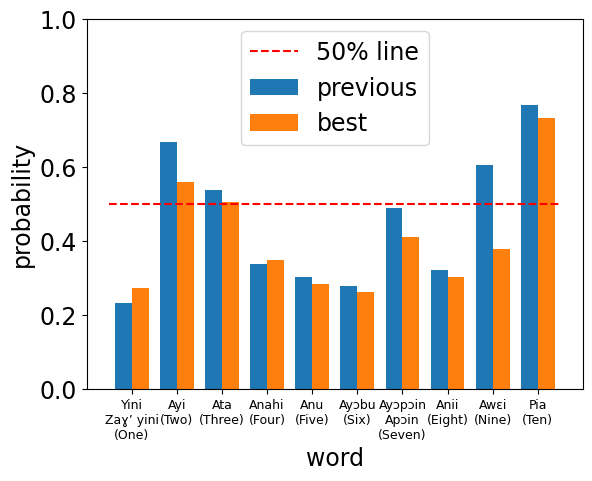

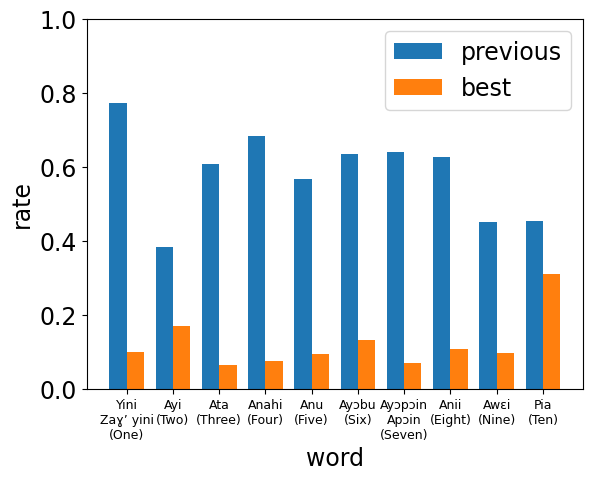

In [25]:
samples = 10000
y_1_of_1_best = [result_1_of_1_best[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
full_width = 0.75
n_bars = 2
width = full_width / n_bars
plt.rcParams.update({'font.size': 17})
plt.ylim([0, 1])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*0,
        [result_1_of_1[name]['correct']/samples for name in SORTED_KEYS_NUMBERS],
        width=width, label='previous')
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*1,
        y_1_of_1_best,
        width=width, label='best')
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('probability of matching correct number 1 to 1')
plt.ylabel('probability')
plt.xlabel('word')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_prob_comparison.pdf'),
            bbox_inches='tight')
plt.show()

y_bad_1_of_1_best = [result_1_of_1_best[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
plt.ylim([0, 1])
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*0,
        [result_1_of_1[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS],
        width=width, label='previous')
plt.bar(np.arange(len(SORTED_KEYS_NUMBERS))-full_width/2+width/2+width*1,
        y_bad_1_of_1_best,
        width=width, label='best')
plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS)), y_names, fontsize=9)
#plt.title('indecision rate when matching 1 to 1')
plt.ylabel('rate')
plt.xlabel('word')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_indec_comparison.pdf'),
            bbox_inches='tight')
plt.show()
plt.rcParams.update(matplotlib.rcParamsDefault)

In [43]:
def f(values, groups):
        vector_norm = {
            alg: values[i]
            for i, alg in enumerate(ALGS_NORM_LIST)
        }
        vector_match = {
            alg: values[len(ALGS_NORM_LIST)+i]
            for i, alg in enumerate(ALGS_MATCH_LIST)
        }
        num = 1000
        while True:
            result = compare_cross_many(groups, 'top', samples=num, n=1,
                                        algs_norm=vector_norm, algs_match=vector_match, verbose=False)
            correct = np.array([d['correct']/num for d in result.values()])
            indecision = np.array([d['indecisions']/num for d in result.values()])
            result = -(correct.mean()/correct.std())/(indecision.mean()/indecision.std())**0.5
            if not np.isnan(result):
                break
        #print([str(v)[:5] for v in values], result)
        return result

def find_best_vectors(groups):
    def print_best(*args, **kwargs):
        print('best', args, kwargs)
    num_params = len(ALGS_NORM_LIST) + len(ALGS_MATCH_LIST)
    results = scipy.optimize.differential_evolution(
        f,
        args=(groups,),
        callback=print_best,
        #np.array([-0.9 for i in range(num_params)]),
        bounds=[[0, 1] for _ in range(num_params)],
        workers=-1,
        #popsize=10,
        #recombination=0.01,
        #method='Nelder-Mead'
    ).x
    return results

In [314]:
print(find_best_vectors(groups_numbers))

best (array([0.4903871 , 0.87935077, 0.80281287, 0.32346618, 0.48589675,
       0.24734877, 0.85190753, 0.77801872]),) {'convergence': 0.20431788091473507}
best (array([0.4903871 , 0.87935077, 0.80281287, 0.32346618, 0.48589675,
       0.24734877, 0.85190753, 0.77801872]),) {'convergence': 0.23731593433307138}
best (array([0.56416457, 0.72240173, 0.72345272, 0.23956453, 0.22520718,
       0.1247425 , 0.92449766, 0.67440914]),) {'convergence': 0.24529613186618218}
best (array([0.56416457, 0.72240173, 0.72345272, 0.23956453, 0.22520718,
       0.1247425 , 0.92449766, 0.67440914]),) {'convergence': 0.2489700514418583}
best (array([0.56416457, 0.72240173, 0.72345272, 0.23956453, 0.22520718,
       0.1247425 , 0.92449766, 0.67440914]),) {'convergence': 0.2776898853420144}
best (array([0.61944136, 0.45343306, 0.63291738, 0.2637707 , 0.02988897,
       0.22265077, 0.82409547, 0.59678102]),) {'convergence': 0.28786415507519597}
best (array([0.61944136, 0.45343306, 0.63291738, 0.2637707 , 0.029

### Match with $x$ out of 6

In [273]:
n = 6
values = range(1, n+1)
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
result_x_of_6 = {
    i: compare_cross_many(groups_numbers, 'min', samples=samples, n=n, select_n=i,
                          algs_norm=algs_norm, algs_match=algs_match)
    for i in values
}

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


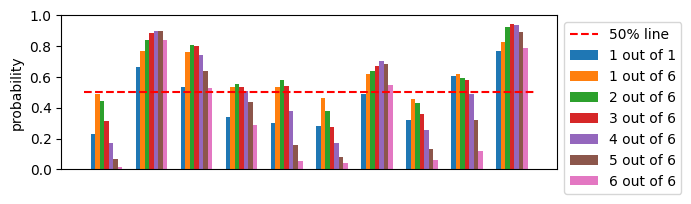

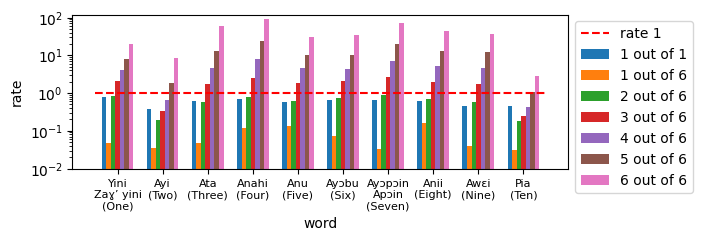

In [275]:
full_width = 0.7
n_bars = len(result_x_of_6) + 1
width = full_width / n_bars
samples = 10000
figsize = (6.4, 2)

plt.figure(figsize=figsize)
plt.ylim([0, 1])
x = np.arange(len(SORTED_KEYS_NUMBERS))
plt.bar(x-full_width/2+width/2+width*0, y_1_of_1, width, label='1 out of 1')
for i, d in result_x_of_6.items():
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*i, y, width, label=str(i)+' out of {}'.format(n))    
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
#plt.xticks(x, y_names, fontsize=8)
plt.xticks([], [])
#plt.title('probability of matching correctly by matching $x$ out of {}'.format(n))
plt.ylabel('probability')
#plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_n_prob.pdf'), bbox_inches='tight')
plt.show()

y_max = max(1, max(
    d['indecisions']/samples
    for result in result_x_of_6.values()
    for d in result.values()
))
if y_max > 1:
    y_max *= 1.2
plt.figure(figsize=figsize)
plt.ylim([0.01, 120])
plt.bar(x-full_width/2+width/2+width*0, y_bad_1_of_1, width, label='1 out of 1', log=True)
for i, d in result_x_of_6.items():
    y = [d[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*i, y, width, label=str(i)+' out of {}'.format(n), log=True)
plt.plot([-0.5, 9.5], [1]*2, 'r--', label='rate 1')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xticks(x, y_names, fontsize=8)
#plt.title('indecision rate watch matching $x$ out of {}'.format(n))
plt.ylabel('rate')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_n_indec.pdf'), bbox_inches='tight')
plt.show()

### Match 1 out of $x$

In [284]:
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
values = [1, 2, 4, 8, 16, 32, 64]
result_1_of_x = {
    i: compare_cross_many(groups_numbers, 'top', samples=samples, n=i, select_n=1,
                          algs_norm=algs_norm, algs_match=algs_match)
    for i in values
}

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


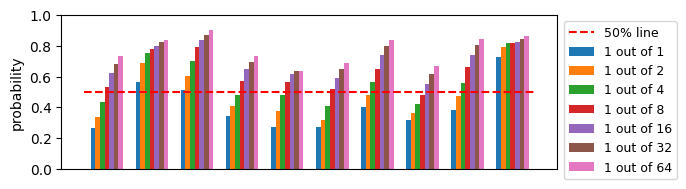

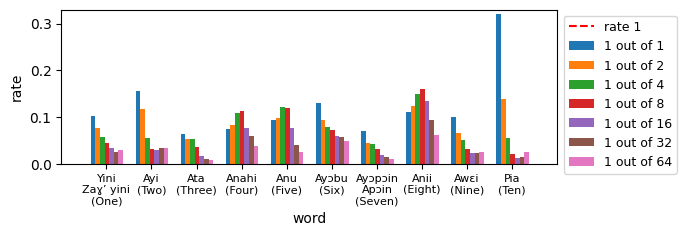

In [298]:
figsize = (6.4, 2)
n = len(values)
width = 0.12/n*6
plt.figure(figsize=figsize)
plt.ylim([0, 1])
x = np.arange(len(SORTED_KEYS_NUMBERS))
for j, (i, d) in enumerate(result_1_of_x.items()):
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='1 out of {}'.format(i))
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize=9)
#plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS))+3*width, y_names, fontsize=8)
plt.xticks([], [])
#plt.title('probability of matching correctly by matching 1 out of $x$'.format(n))
plt.ylabel('probability')
#plt.xlabel('word')
#plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
xmin, xmax, _, _ = plt.axis()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_n_prob.pdf'), bbox_inches='tight')
plt.show()

plt.figure(figsize=figsize)
plt.ylim([0, 0.33])
plt.xlim(xmin, xmax)
for j, (i, d) in enumerate(result_1_of_x.items()):
    y = [d[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='1 out of {}'.format(i))
if y_max > 1:
    plt.plot([-0.5+3/n*width, 9.5+3/n*width], [1]*2, 'r--', label='rate 1')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize=9)
plt.xticks(x, y_names, fontsize=8)
#plt.title('indecision rate watch matching 1 ouf ot $x$')
plt.ylabel('rate')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_n_indec.pdf'), bbox_inches='tight')
plt.show()

#### With noise filtered

In [68]:
groups_filtered = {}

for name, group in groups.items():
    data = zip(group.recordings(), in_word_similarities[name][(('metaphone',), ('jaro',))])
    data = sorted(data, key=lambda x: x[1], reverse=True)
    selected = list(zip(*data[:int(0.5*len(data))]))[0]
    groups_filtered[name] = Group(recordings=selected, identifier=name)

groups_numbers_filtered = {name: v for name, v in groups_filtered.items() if name in SORTED_KEYS_NUMBERS}

In [69]:
in_word_similarities_filtered = {
    name: get_in_word_similarities(group)
    for name, group in groups_filtered.items()
}

Two
No
Seven
Four
Nine
One
Three
Six
Five
Ten
Yes
Eight


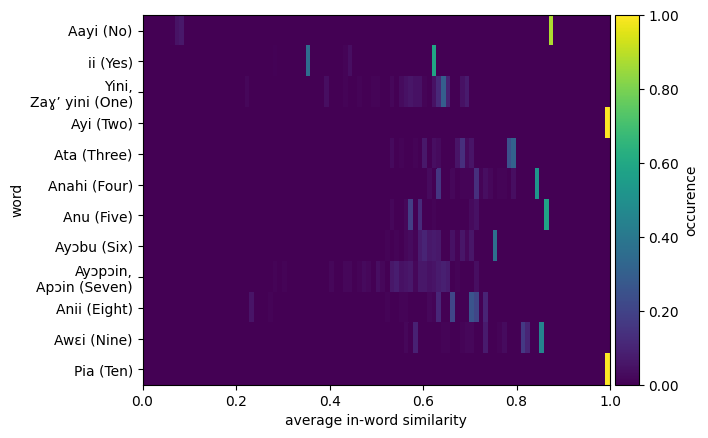

In [70]:
plot_average_in_word_multi(in_word_similarities_filtered, 'metaphone', 'jaro')

In [286]:
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
values = [1, 2, 4, 8, 16, 32, 64]
result_1_of_x_filtered = {
    i: compare_cross_many(groups_numbers_filtered, 'top', samples=samples, n=i, select_n=1,
                          algs_norm=algs_norm, algs_match=algs_match)
    for i in values
}

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


In [341]:
get_summary_data = lambda x, key: np.array([d[key]/samples for d in x[64].values()])

print('Unfiltered')
vals = get_summary_data(result_1_of_x, 'correct')
print(vals.mean(), '+/-', vals.std())
vals = get_summary_data(result_1_of_x, 'indecisions')
print(vals.mean(), '+/-', vals.std())
print('Filtered')
vals = get_summary_data(result_1_of_x_filtered, 'correct')
print(vals.mean(), '+/-', vals.std())
vals = get_summary_data(result_1_of_x_filtered, 'indecisions')
print(vals.mean(), '+/-', vals.std())

Unfiltered
0.7732900000000001 +/- 0.08882322275171058
0.03019 +/- 0.015228686745744032
Filtered
0.9041099999999999 +/- 0.08993117868681585
0.007000000000000001 +/- 0.010556230387785217


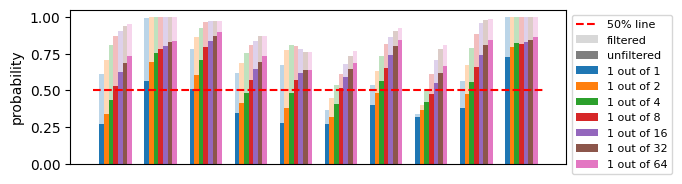

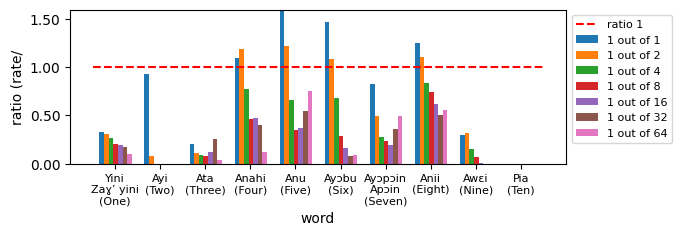

In [295]:
figsize = (6.4, 2)
n = len(values)
width = 0.12/n*6
plt.figure(figsize=figsize)
plt.ylim([0, 1.05])
x = np.arange(len(SORTED_KEYS_NUMBERS))
for j, (i, d) in enumerate(result_1_of_x_filtered.items()):
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width,
            alpha=0.3)
color = plt.bar(x, [0]*len(x), alpha=0.3, label='filtered')[0].get_facecolor()
plt.bar(x, [0]*len(x), label='unfiltered', color=color[:3])
plt.gca().set_prop_cycle(None)
for j, (i, d) in enumerate(result_1_of_x.items()):
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='1 out of {}'.format(i))
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize=8)
#plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS))+3*width, y_names, fontsize=8)
plt.xticks([], [])
#plt.title('probability of matching correctly by matching 1 out of $x$'.format(n))
plt.ylabel('probability')
#plt.xlabel('word')
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
xmin, xmax, _, _ = plt.axis()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_n_prob_filtered.pdf'), bbox_inches='tight')
plt.show()

plt.figure(figsize=figsize)
plt.ylim([0, 1.6])
plt.xlim(xmin, xmax)
for j, ((i, d1), (_, d2)) in enumerate(zip(result_1_of_x_filtered.items(), result_1_of_x.items())):
    y = [d1[name]['indecisions']/d2[name]['indecisions'] for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='1 out of {}'.format(i))
plt.plot([-0.5, 9.5], [1]*2, 'r--', label='ratio 1')
plt.gca().set_prop_cycle(None)
#for j, (i, d) in enumerate(result_1_of_x.items()):
#    y = [d[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
#    plt.bar(x-full_width/2+width/2+width*j, y, width)
#if y_max > 1:
#    plt.plot([-0.5+3/n*width, 9.5+3/n*width], [1]*2, 'r--', label='rate 1')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize=8)
plt.xticks(x, y_names, fontsize=8)
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
#plt.title('indecision rate watch matching 1 ouf ot $x$')
plt.ylabel('ratio (rate/')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_1_n_indec_filtered.pdf'), bbox_inches='tight')
plt.show()

### Best

In [145]:
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
values = [1, 2, 4, 8, 16, 32]
result_best_of_x = {
    i: compare_cross_many(groups_numbers, 'best', samples=samples, n=8, select_n=i,
                          algs_norm=algs_norm, algs_match=algs_match)
    for i in values
}

Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight


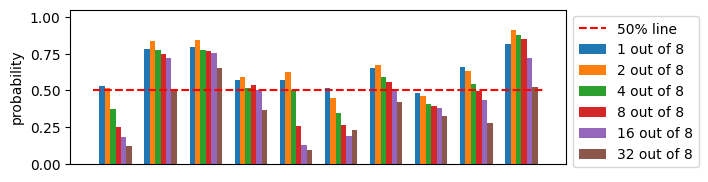

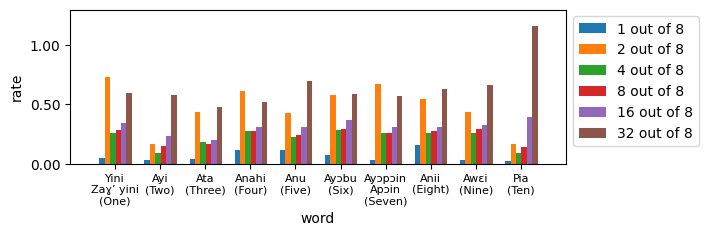

In [278]:
figsize = (6.4, 2)
n = len(values)
width = 0.12/n*6
plt.figure(figsize=figsize)
plt.ylim([0, 1.05])
x = np.arange(len(SORTED_KEYS_NUMBERS))
for j, (i, d) in enumerate(result_best_of_x.items()):
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='{} out of 8'.format(i))
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
#plt.xticks(np.arange(len(SORTED_KEYS_NUMBERS))+3*width, y_names, fontsize=8)
plt.xticks([], [])
#plt.title('probability of matching correctly by matching 1 out of $x$'.format(n))
plt.ylabel('probability')
#plt.xlabel('word')
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
xmin, xmax, _, _ = plt.axis()
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_best_to_1_n_prob.pdf'), bbox_inches='tight')
plt.show()

plt.figure(figsize=figsize)
plt.ylim([0, 1.3])
plt.xlim(xmin, xmax)
x = np.arange(len(SORTED_KEYS_NUMBERS))
for j, (i, d) in enumerate(result_best_of_x.items()):
    y = [d[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*j, y, width, label='{} out of 8'.format(i))
#if y_max > 1:
#    plt.plot([-0.5+3/n*width, 9.5+3/n*width], [1]*2, 'r--', label='rate 1')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xticks(x, y_names, fontsize=8)
#plt.title('indecision rate watch matching 1 ouf ot $x$')
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
plt.ylabel('rate')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_best_to_1_n_indec.pdf'), bbox_inches='tight')
plt.show()

### Combination

In [80]:
samples = 10000
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
values = range(1, 11)

result_combination = {}
for i in range(1, 17):
    if i not in result_combination:
        result_combination[i] = {}
    for j in range(i, 33):
        print(i, j)
        if j in result_combination[i]:
            continue
        result_combination[i][j] = compare_cross_many(groups_numbers, 'top' if i == 1 else 'min',
                                                      samples=samples, n=j, select_n=i,
                          algs_norm=algs_norm, algs_match=algs_match)

1 1
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 2
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 3
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 4
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 5
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 6
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 7
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 8
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 9
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 10
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 11
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 12
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 13
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 14
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 15
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 16
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 17
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 18
Two
Seven
Four
Nine
One
Three
Six
Five
Ten
Eight
1 19
Two
Seven
Four
Nine
One
Three
Si

KeyboardInterrupt: 

In [350]:
get_mix = lambda key: np.array([
    [
        [d[key]/10000 for d in result_combination[i][j].values()]
        if j >= i else
        [0]*10
        for j in range(1, 33)
    ]
    for i in range(1, 6)
])
mix_correct = get_mix('correct')
mix_indecision = get_mix('indecisions')
mix_mean1 = mix_correct.mean(axis=2)
mix_std1 = mix_correct.std(axis=2)
mix_normed1 = mix_mean1 / mix_std1
mix_mean2 = mix_indecision.mean(axis=2)
mix_std2 = mix_indecision.std(axis=2)
mix_normed2 = mix_mean2 / mix_std2
mix_normed_all = mix_normed1 / np.sqrt(mix_mean2)#np.sqrt(mix_normed2)

/tmp/ipykernel_29/479453008.py:14: RuntimeWarning: invalid value encountered in divide
  mix_normed1 = mix_mean1 / mix_std1
/tmp/ipykernel_29/479453008.py:17: RuntimeWarning: invalid value encountered in divide
  mix_normed2 = mix_mean2 / mix_std2


/tmp/ipykernel_29/2980799001.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),


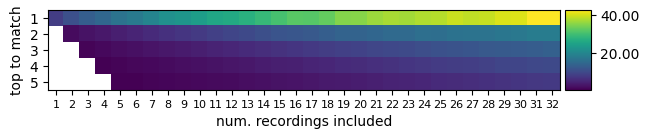

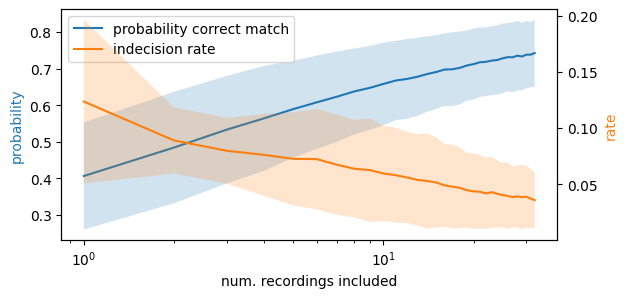

In [351]:
plt.figure(figsize=(7, 3))
ax = plt.gca()
ax.set_aspect('equal')
im = plt.pcolor(mix_normed_all)
im.set_edgecolor('face')
plt.gca().invert_yaxis()
plt.yticks(np.arange(mix_normed_all.shape[0])+0.5,
           labels=np.arange(mix_normed_all.shape[0])+1)
plt.ylabel('top to match')
plt.xticks(np.arange(mix_normed_all.shape[1])+0.5,
           labels=np.arange(mix_normed_all.shape[1])+1,
           fontsize=8)
plt.xlabel('num. recordings included')
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05),
             format=tkr.FormatStrFormatter('%.2f'))
plt.savefig(os.path.join('plots', 'mix.pdf'), bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots(figsize=(6.4, 3))
ax2 = ax1.twinx()
x = np.arange(mix_normed_all.shape[1])+1
l1 = ax1.plot(x, mix_mean1[0], label='probability correct match')
ax1.fill_between(x, mix_mean1[0]-mix_std1[0], mix_mean1[0]+mix_std1[0], alpha=0.2)
ax1.set_xlabel('num. recordings included')
ax1.set_ylabel('probability', color=l1[0].get_color())
ax2.plot([], [])
ax2.fill_between([], [], [])
l2 = ax2.plot(x, mix_mean2[0], label='indecision rate')
ax2.fill_between(x, mix_mean2[0]-mix_std2[0], mix_mean2[0]+mix_std2[0], alpha=0.2)
ax2.set_ylabel('rate', color=l2[0].get_color())
plt.xscale('log')
ax1.legend(l1+l2, [l1[0].get_label(), l2[0].get_label()], loc='upper left')
plt.savefig(os.path.join('plots', 'mix_1_plot.pdf'), bbox_inches='tight')
plt.show()

In [27]:
probs = np.linspace(0.3, 0.4, 5)
samples = 10
algs_norm = ['soundex', 'nysiis', 'metaphone']
algs_match = ['damerau', 'jaro', 'winkler']
num = 4
result_1_of_x_char_probs = {
    prob: compare_cross_many(groups_numbers, 'top', samples=samples, n=num, select_n=1,
                          algs_norm=algs_norm, algs_match=algs_match, min_probability=prob,
                            or_best=True, or_best_char=True,
                            choose_best=True)
    for prob in probs
}

Two


NameError: name 'timestap' is not defined

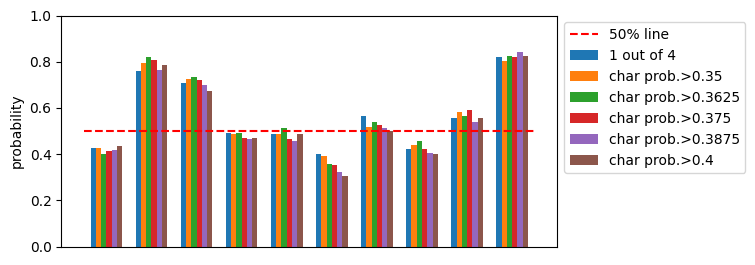

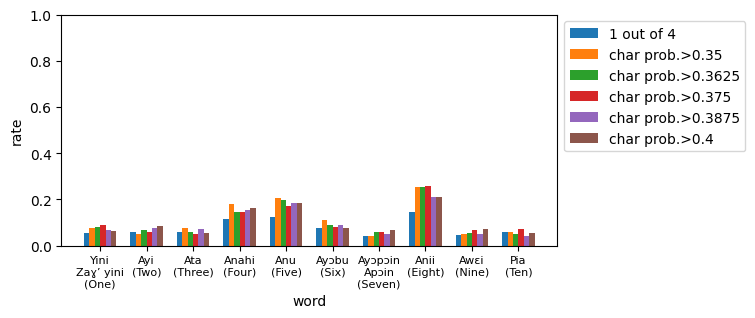

In [92]:
figsize = (6.4, 3)
full_width = 0.7
n_bars = len(result_1_of_x_char_probs) + 1
width = full_width / n_bars

plt.figure(figsize=figsize)
plt.ylim([0, 1])
x = np.arange(len(SORTED_KEYS_NUMBERS))
plt.bar(x-full_width/2+width/2+width*0,
        [result_1_of_x[num][name]['correct']/10000 for name in SORTED_KEYS_NUMBERS],
        width, label='1 out of {}'.format(num))
for j, (i, d) in enumerate(result_1_of_x_char_probs.items()):
    y = [d[name]['correct']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*(j+1), y, width, label='char prob.>{}'.format(i))    
plt.plot([-0.5, 9.5], [0.5]*2, 'r--', label='50% line')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
#plt.xticks(x, y_names, fontsize=8)
plt.xticks([], [])
#plt.title('probability of matching correctly by matching $x$ out of {}'.format(n))
plt.ylabel('probability')
#plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_{}_char_prob.pdf'.format(num)), bbox_inches='tight')
plt.show()

plt.figure(figsize=figsize)
plt.ylim([0, 1])
plt.bar(x-full_width/2+width/2+width*0,
        [result_1_of_x[num][name]['indecisions']/10000 for name in SORTED_KEYS_NUMBERS],
        width, label='1 out of {}'.format(num))
for j, (i, d) in enumerate(result_1_of_x_char_probs.items()):
    y = [d[name]['indecisions']/samples for name in SORTED_KEYS_NUMBERS]
    plt.bar(x-full_width/2+width/2+width*(j+1), y, width, label='char prob.>{}'.format(i))  
#plt.plot([-0.5, 9.5], [1]*2, 'r--', label='rate 1')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.xticks(x, y_names, fontsize=8)
#plt.title('indecision rate watch matching $x$ out of {}'.format(n))
plt.ylabel('rate')
plt.xlabel('word')
plt.savefig(os.path.join(PLOTS_DIR, 'cross-word_1_to_{}_char_indec.pdf'.format(num)), bbox_inches='tight')
plt.show()

### Mix